# Self-supervised and multi-modal representation Learning: Notebook 2

Here we will build a simple encoder for light curves, and try to train it to learn useful representation via masked autoencoding (i.e., predicting a missing part of the light curve).

## Light curve encoding via masked self-supervised learning

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

%load_ext autoreload
%autoreload 2

### Data loading and pre-processing

Let's start by loading the bulk lightcurve sample. Note that we only load one `.parquet` file here for illustration, but there are a huge number available at https://irsa.ipac.caltech.edu/Missions/ztf.html (under "Lightcurve Bulk Download"). 

Data release notes: https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/ztf_release_notes_latest.

In [2]:
bulk_df = pq.read_table("../data/lightcurves_bulk/ztf_000858_zg_c01_q1_dr19.parquet").to_pandas()
bulk_df.head()

,objectid,filterid,fieldid,rcid,objra,objdec,nepochs,hmjd,mag,magerr,clrcoeff,catflags
0,858101100000000,1,858,0,121.166801,74.119148,181,"[58247.17837, 58347.49742, 58362.49149, 58368....","[20.790735, 20.31993, 20.606007, 21.471548, 21...","[0.20726836, 0.15888518, 0.18998587, 0.2709626...","[-0.08939283, -0.009556137, -0.006476993, -0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,858101100000001,1,858,0,119.970047,74.188736,610,"[58207.2526, 58207.2744, 58210.25232, 58229.15...","[16.1671, 16.162312, 16.10719, 16.154564, 16.1...","[0.014392191, 0.014376102, 0.014196091, 0.0143...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
2,858101100000002,1,858,0,120.869438,74.136711,610,"[58207.25263, 58207.27442, 58210.25234, 58229....","[16.092796, 16.05233, 16.037151, 16.08971, 16....","[0.014150625, 0.014026101, 0.01398062, 0.01414...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
3,858101100000003,1,858,0,121.366310,74.105324,598,"[58207.25264, 58207.27444, 58210.25236, 58229....","[17.77512, 17.661259, 17.747467, 17.815546, 17...","[0.02695156, 0.02533685, 0.026544018, 0.027565...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
5,858101100000005,1,858,0,121.104126,74.121140,379,"[58244.2015, 58247.17837, 58255.19753, 58346.4...","[20.145699, 20.32862, 20.048012, 20.142803, 19...","[0.14019924, 0.159865, 0.13053155, 0.13990413,...","[-0.0957851, -0.08939283, -0.0756015, -0.03298...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


The data contain variable number of light curves. Let's exclude those with less than 5 observations, and for those with >100 observations pick 100 at random. Pad the shorter ones with zeros up to a length of 100. We'll also create a padding mask to be used in the encoder.

In [4]:
def preprocess_bulk_lightcurves(bulk_df, n_min_obs=5, n_max_obs=100):
    """ Preprocess the bulk light curves by filtering out entries with < `n_min_obs` observations and randomly sampling `n_max_obs` observations from entries with > `n_max_obs` observations. 
    Pad the entries with < `n_max_obs` observations with zeros. Return the filtered dataframe and a mask array indicating which entries were padded with zeros.
    """

    # Filter out entries with < 5 observations
    filtered_df = bulk_df[bulk_df['mag'].apply(lambda x: len(x) >= n_min_obs)]  

    # For entries with > n_max_obs observations, randomly sample 200 observations (hmjd, mag, and magerr with same sample) from the light curve
    # Pad the entries to n_max_obs observations with zeros and create a mask array
    mask_list = [] 
    for i in filtered_df.index:

        # If there are more than n_max_obs observations, randomly sample n_max_obs observations
        if len(filtered_df.loc[i]['mag']) > n_max_obs:
            mask = np.ones(n_max_obs, dtype=bool)
            mask_list.append(mask)

            # Randomly sample n_max_obs observations
            indices = np.random.choice(len(filtered_df.loc[i]['mag']), n_max_obs)
            filtered_df.at[i, 'hmjd'] = filtered_df.loc[i]['hmjd'][indices]

            # Sort the observations by time
            sorted_indices = np.argsort(filtered_df.loc[i]['hmjd'])
            filtered_df.at[i, 'hmjd'] = filtered_df.loc[i]['hmjd'][sorted_indices]
            filtered_df.at[i, 'mag'] = filtered_df.loc[i]['mag'][sorted_indices]
            filtered_df.at[i, 'magerr'] = filtered_df.loc[i]['magerr'][sorted_indices]

        # Otherwise, pad the arrays with zeros
        else:
            mask = np.zeros(n_max_obs, dtype=bool)
            mask[:len(filtered_df.loc[i]['mag'])] = True
            mask_list.append(mask)
            
            # Pad the arrays with zeros
            filtered_df.at[i, 'mag'] = np.pad(filtered_df.loc[i]['mag'], (0, n_max_obs - len(filtered_df.loc[i]['mag'])), 'constant')
            filtered_df.at[i, 'magerr'] = np.pad(filtered_df.loc[i]['magerr'], (0, n_max_obs - len(filtered_df.loc[i]['magerr'])), 'constant')
            filtered_df.at[i, 'hmjd'] = np.pad(filtered_df.loc[i]['hmjd'], (0, n_max_obs - len(filtered_df.loc[i]['hmjd'])), 'constant')

    mask_ary = np.array(mask_list)
    return filtered_df, mask_ary

In [5]:
filtered_df, mask_ary = preprocess_bulk_lightcurves(bulk_df)

This is a very noisy sample -- are there any quality cuts that might be useful? For example, a cut based on a correlation function of the points as a function of time-spacing?

### Light curve encoder

We'll start with a simple transformer-based light curve encoder. Since transformers are inherenently permutation-equivariant (i.e., insensitive to ordering -- a permutation of the inputs leads to a corresponding permuation of the outputs), we'll need to add time encodings to "tell" the transformer the time corresponding to each observation. 

This is a simple way to be able to deal with variable-length, heterogeneously sampled light curves. There are many extensions to this basic idea, see e.g.
- https://arxiv.org/abs/2309.16316
- https://arxiv.org/abs/2308.06404
- https://www.aanda.org/articles/aa/full_html/2023/02/aa43928-22/aa43928-22.html

and feel free to implement ideas from these or others, e.g. learnable time encoding bases.

In [7]:
import math

import torch
import torch.nn as nn
import pytorch_lightning as pl

from models.transformer_utils import Transformer

PyTorch has a boilerplate Transformer implementation (`nn.TransformerEncoder`), but we'll use a lower-level implementation in `models/transformer_utils.py` for a bit more flexibility if we need it. Feel free to play around with either in the block below, inspecting the outputs and their shape, effect of masking, effect of changing hyperparameters.

In [11]:
# # Transformer from torch.nn
# encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
# transformer = nn.TransformerEncoder(encoder_layer, num_layers=6,)

# Our transformer from models/transformer_utiles.py
transformer = Transformer(emb=128, heads=2, depth=2, ff_hidden_mult=4)  # Instantiate

# Dummy inputs
mask = torch.ones((1, 100), dtype=torch.bool)
x = torch.randn((1, 100, 128))

# Forward pass
transformer(x, mask)

tensor([[[-0.5223,  1.9890,  0.3405,  ..., -0.2898,  0.5459,  0.4535],
         [ 0.9029,  1.1916,  0.8817,  ...,  0.2389,  1.2902, -0.8616],
         [ 0.5628,  0.7716,  1.2903,  ...,  1.0174,  2.8283,  2.1492],
         ...,
         [ 0.6622, -0.1294,  0.5246,  ...,  0.7828, -0.8624,  1.0914],
         [ 1.7917,  0.1058,  0.5025,  ...,  0.4246, -0.0257,  0.3232],
         [ 1.1020,  1.0096, -0.2149,  ..., -0.5904,  0.1456,  0.3684]]],
       grad_fn=<NativeLayerNormBackward0>)

Now let's implement the light curve encoder. For more details on the time-encoding via fourier features, please see e.g., [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#Positional-encoding), from where it was adapted. We'll include the time encoding depdence simply by adding the embeddings to the linear embeddings of individual light curve data points.

In [15]:
class TimePositionalEncoding(nn.Module):
    """ Time encodings for Transformer. 
    """

    def __init__(self, d_emb):
        """
        Inputs
            d_emb - Dimensionality when projecting to the fourier feature basis.
        """
        super().__init__()
        self.d_emb = d_emb

    def forward(self, t):
        pe = torch.zeros(t.shape[0], t.shape[1], self.d_emb).to(t.device)  # (B, T, D)
        div_term = torch.exp(torch.arange(0, self.d_emb, 2).float() * (-math.log(10000.0) / self.d_emb))[None, None, :].to(t.device)  # (1, 1, D / 2)
        t = t.unsqueeze(2)  # (B, 1, T)
        pe[:, :, 0::2] = torch.sin(t * div_term)  # (B, T, D / 2)
        pe[:, :, 1::2] = torch.cos(t * div_term)  # (B, T, D / 2)
        return pe  # (B, T, D)

class TransformerWithTimeEmbeddings(nn.Module):
    """ Transformer encoer.
    """

    def __init__(self, n_out=1, **kwargs):
        """
        :param n_out: Number of outputs per sequence element (e.g., number of bands).
        :param kwargs: Transformer arguments.
        """
        super().__init__()
        
        self.embedding_mag = nn.Linear(in_features=1, out_features=kwargs['emb'])
        self.embedding_t = TimePositionalEncoding(kwargs['emb'])
        self.transformer = Transformer(**kwargs)
        self.projection = nn.Linear(in_features=kwargs['emb'], out_features=n_out)

    def forward(self, x, t, mask=None):
        """
        :param x: Input sequence (B, T, 1).
        :param t: Time sequence (B, T).
        :param mask: Padding mask (B, T).
        :return: Output sequence (B, T, n_out).
        """
        t = t - t[:, 0].unsqueeze(1)  # (B, T)  # Relative time
        t_emb = self.embedding_t(t)  # (B, T, D)  # Project to embedding dimension of transformer
        x = self.embedding_mag(x) + t_emb  # (B, T, D)  # Add time embeddings to magnitude embeddings
        x = self.transformer(x, mask)  # (B, T, D)  # Transformer
        x = self.projection(x)  # (B, T, n_out)  # Project each sequence element (independently) to output dim

        return x

transformer = TransformerWithTimeEmbeddings(n_out=1, emb=128, heads=2, depth=2)

### Dataset prep and masking

In [20]:
mag = filtered_df['mag'].array
magerr = filtered_df['magerr'].array
hmjd = filtered_df['hmjd'].array

# Convert to torch tensors
mag = torch.Tensor(mag)
magerr = torch.Tensor(magerr)
hmjd = torch.Tensor(hmjd)
mask = torch.Tensor(mask_ary).to(torch.bool)

# Standardize mag and magerr
mag_mean = mag.mean()
mag_std = mag.std()
mag = (mag - mag_mean) / mag_std
magerr = magerr / mag_std

Write a convenience function to get masks for the encoder.

In [21]:
# Convenience function to get random masks

def get_random_mask(padding_mask, f_mask=0.15):
    """ Get a random contiguous masks for the input sequence.
    :param padding_mask: Padding mask (B, T).
    :param f_mask: Fraction of mask to keep.
    :return: Mask (B, T).
    """
    mask = torch.ones_like(padding_mask)
    mask_pred = torch.ones_like(padding_mask)
    for i in range(padding_mask.shape[0]):
        n_obs = padding_mask[i].sum().item()
        n_obs_to_keep = int(n_obs * f_mask)
        start = torch.randint(0, n_obs - n_obs_to_keep + 1, (1,)).item()
        end = start + n_obs_to_keep

        # Mask containing observations to be kept
        mask[i, start:end] = False  # Mask out observations from start to end
        mask[i, n_obs:] = False

        # Mask only containing observations to be predicted
        mask_pred[i, end:n_obs] = False
        mask_pred[i, :start] = False
        mask_pred[i, start:end] = True
        mask_pred[i, n_obs:] = False
        
    return mask, mask_pred

# Test the mask function

f_mask = 0.15

mask_test = mask[1244:]
mask_in, mask_pred = get_random_mask(mask_test, f_mask=f_mask)  # Mask out 15% of observations

Mask


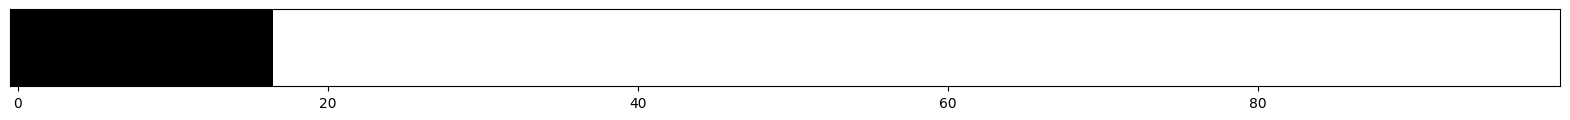

Mask in: original mask with 0.15 of observations masked out


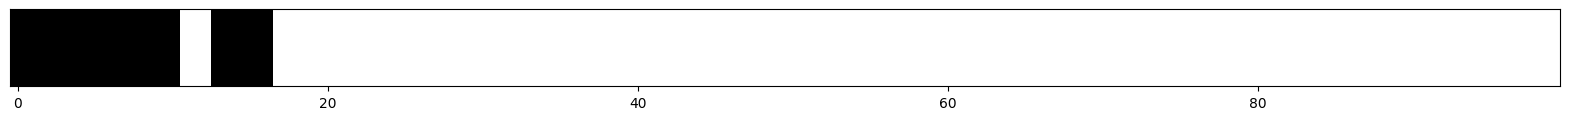

Mask pred: observations to be predicted


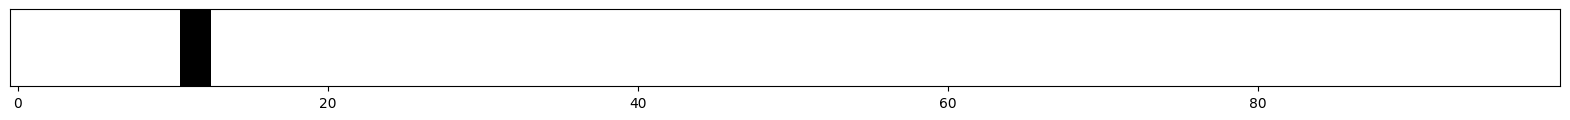

In [22]:
# Function to plot a mask
def plot_mask(mask):
    """ `mask` is a 1D boolean array.
    """
    plt.figure(figsize=(20, 1))
    plt.imshow(mask[None, :], aspect='auto', cmap='binary', vmin=0, vmax=1)
    plt.yticks([])
    plt.show()

print("Mask")
plot_mask(mask_test[0].detach().numpy())

print(f"Mask in: original mask with {f_mask} of observations masked out")
plot_mask(mask_in[0].detach().numpy())

print("Mask pred: observations to be predicted")
plot_mask(mask_pred[0].detach().numpy())

Let's pass a small batch through our lightcurve encoder.

In [32]:
n_small_batch = 4

out = transformer(mag[:n_small_batch].unsqueeze(-1), hmjd[:n_small_batch], mask[:n_small_batch])  # Unsqueeze just adds a channel dimension (B, T, 1)
out.shape

torch.Size([4, 100, 1])

### Train masked autoencoder

In [33]:
class MaskedLightCurveEncoder(pl.LightningModule):
    def __init__(self, f_mask=0.2, transformer_kwargs={"n_out":1, "emb":128, "heads":2, "depth":4}, optimizer_kwargs={}, lr=1e-3):
        super().__init__()

        self.optimizer_kwargs = optimizer_kwargs
        self.lr = lr
        self.f_mask = f_mask

        self.net = TransformerWithTimeEmbeddings(**transformer_kwargs)

    def forward(self, x, t, mask=None):
        x_mean, x_std = x.mean(axis=1, keepdims=True), x.std(axis=1, keepdims=True)
        x = (x[..., None] - x_mean[..., None]) / x_std[..., None]
        x = self.net(x, t, mask)
        return x * x_std[..., None] + x_mean[..., None]

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}

    def masked_pred(self, x, t, padding_mask, f_mask=0.15):
        # Get random mask and predict with masked inputs; then, return only the unmasked outputs
        mask_in, mask_pred = get_random_mask(padding_mask, f_mask=f_mask)
        x_masked = x.clone()
        x_masked[~mask_in] = 0
        x_pred = self(x_masked, t, mask=padding_mask)[..., 0]  
        return x[mask_pred], x_pred[mask_pred]
    
    def training_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("val_loss", loss, on_epoch=True)
        return loss

In [42]:
mlce = MaskedLightCurveEncoder(f_mask=0.1, lr=6e-4)

In [44]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.
batch_size = 32
n_samples_val = int(val_fraction * mag.shape[0])

dataset = TensorDataset(mag, hmjd, mask)

dataset_train, dataset_val = random_split(dataset, [mag.shape[0] - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [45]:
trainer = pl.Trainer(max_epochs=10, accelerator='cpu')
trainer.fit(model=mlce, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name | Type                          | Params
-------------------------------------------------------
0 | net  | TransformerWithTimeEmbeddings | 791 K 
-------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.168     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:111: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Evaluation: mask-filling

Let's load another set of bulk-downloaded spectra and see how well the encoder can fill in the masked parts of the light curves (set to zero, the special mask token).

In [39]:
bulk_df_test = pq.read_table("../data/lightcurves_bulk/ztf_000858_zg_c01_q3_dr19.parquet").to_pandas()
filtered_df_test, mask_ary_test = preprocess_bulk_lightcurves(bulk_df_test)

In [40]:
mag_test = filtered_df_test['mag'].array
hmjd_test = filtered_df_test['hmjd'].array

# Convert to torch tensors
mag_test = torch.Tensor(mag_test)
hmjd_test = torch.Tensor(hmjd_test)
mask_test = torch.Tensor(mask_ary_test).to(torch.bool)

# Standardize mag
mag_test = (mag_test - mag_mean) / mag_std

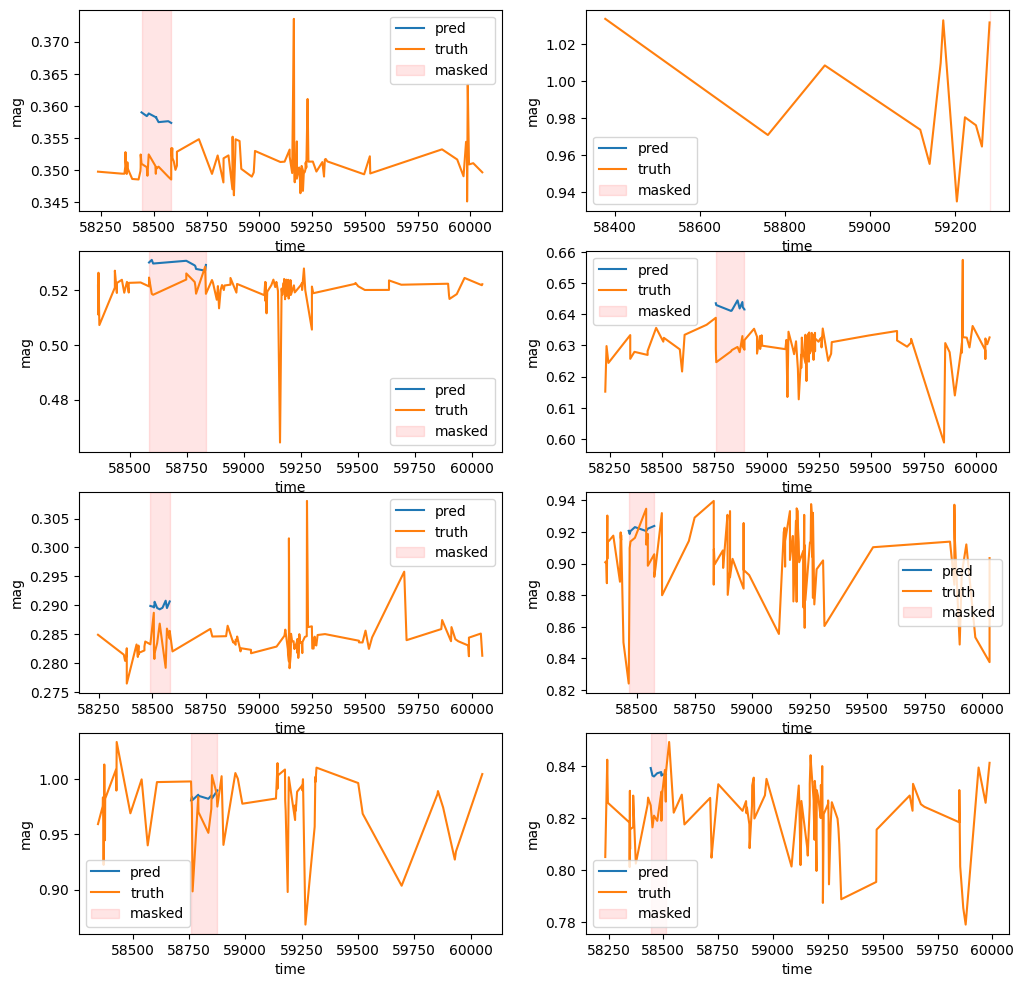

In [41]:
fig, ax = plt.subplots(4, 2, figsize=(12, 12))

for i in range(4):
    for j in range(2):
        ii = i * 2 + j

        fill_min, fill_max = 15, 25  # Mask out observations from fill_min to fill_max
        mask_tofill = mask_test[ii:ii + 1].clone()
        mask_tofill[:, fill_min:fill_max + 1] = False

        # Remove zero-padded, masked out elements
        mag_truth = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        mag_test_in = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        hmjd_test_in = hmjd_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]

        mag_test_in[fill_min:fill_max + 1] = 0

        mag_pred = mlce(mag_test_in[None, ...], hmjd_test_in[None, ...],)[0, :, 0].detach().numpy()[fill_min:fill_max + 1]

        ax[i, j].plot(hmjd_test_in[fill_min:fill_max + 1], mag_pred, label='pred')
        ax[i, j].plot(hmjd_test_in, mag_truth, label='truth')

        # Mark the masked observations; if fill_[min/max] is bigger than the number of observations, make it the length of the observations
        fill_min = min(fill_min, len(hmjd_test_in) - 1)
        fill_max = min(fill_max, len(hmjd_test_in) - 1)
        
        ax[i, j].axvspan(hmjd_test_in[fill_min], hmjd_test_in[fill_max], alpha=0.1, color='red', label='masked')
        ax[i, j].legend()

        ax[i, j].set_xlabel('time')
        ax[i, j].set_ylabel('mag')

Not great, but the light curves are very noisy, and we used a simple model trained for a short while. Can you improve the model and/or dataset?